ต้องรักษาลำดับเวลา (time series) ไว้ครับ — ห้าม shuffle ในแกนเวลา
แต่ สามารถ shuffle ระดับ sample ได้ตามปกติ

อธิบายละเอียดนิดนึง 👇

ST-GCN ทำงานกับเวลาอย่างไร

ST-GCN (Spatial-Temporal Graph Convolutional Network) ออกแบบมาเพื่อเรียนรู้

Spatial: ความสัมพันธ์ของ joint ในแต่ละเฟรม

Temporal: การเปลี่ยนแปลงของ joint ข้ามเวลา

โครงสร้าง input ปกติจะเป็นประมาณนี้:

(N, C, T, V, M)


T = time steps (ลำดับเฟรม)

Temporal convolution จะมอง เฟรมที่ t, t+1, t+2 … ต่อเนื่องกัน
ดังนั้นถ้าคุณ shuffle เฟรมใน T → ความหมายของ motion จะพังทันที

อะไร shuffle ได้ / ไม่ได้

✅ shuffle ได้

shuffle ระหว่าง sample (เช่น คนละคลิป, คนละ sequence)

shuffle ใน DataLoader (shuffle=True)

❌ shuffle ไม่ได้

shuffle ลำดับเวลาใน sequence เดียวกัน

สลับเฟรมมั่ว ๆ ภายใน T

แล้ว data augmentation ล่ะ?

ทำได้ แต่ต้องระวัง เช่น:

✔ random temporal crop (ตัดช่วงเวลาต่อเนื่อง)

✔ padding / sliding window

✖ random permutation ของเฟรม

สรุปสั้น ๆ

ST-GCN ต้องการ input แบบ time series

ห้าม shuffle time dimension

shuffle ได้แค่ระดับ sample


STGCNDataset
✔ __getitem__ คืน 1 sequence ต่อ 1 sample

✔ ไม่มีการยุ่งกับ time dimension (T)

✔ ลำดับเฟรมภายใน sample ถูกเก็บไว้ครบ

✔ DataLoader(shuffle=True) จะ shuffle แค่ idx → สลับระดับ sample เท่านั้น

In [20]:
import torch

data = torch.load("stgcn_dataset.pt", map_location="cpu")
print(data.keys())


dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'graph'])


C:\Users\User\AppData\Local\Temp\ipykernel_15304\2671873823.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("stgcn_dataset.pt", map_location="cpu")


In [21]:
print(data["X_train"].shape)  # (N, C, T, V, 1)
print(data["y_train"].shape)  # (N,)
print(data["graph"].shape)    # (3, 17, 17)


torch.Size([714, 3, 30, 17, 1])
torch.Size([714])
torch.Size([3, 17, 17])


In [22]:
X_train = data["X_train"]   # (N, C, T, V, 1)
y_train = data["y_train"]
X_test  = data["X_test"]
y_test  = data["y_test"]
A       = data["graph"]      # (3, V, V)

In [23]:
from torch.utils.data import Dataset, DataLoader, random_split

class STGCNDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

test_dataset = STGCNDataset(X_test, y_test)
test_size = len(test_dataset)
val_size  = test_size // 2
final_test_size = test_size - val_size

val_dataset, final_test_dataset = random_split(
    test_dataset,
    [val_size, final_test_size],
    generator=torch.Generator().manual_seed(42)  # 🔒 reproducible
)

train_loader = DataLoader(
    STGCNDataset(X_train, y_train),
    batch_size=16,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False
)

test_loader = DataLoader(
    final_test_dataset,
    batch_size=16,
    shuffle=False
)


In [24]:
import torch
import torch.nn as nn

class GraphConv(nn.Module):
    def __init__(self, in_channels, out_channels, A):
        super().__init__()
        self.A = nn.Parameter(
            torch.tensor(A, dtype=torch.float32),
            requires_grad=False
        )  # (K, V, V)

        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=1
        )

    def forward(self, x):
        # x: (N*M, C, T, V)
        A = self.A.to(x.device)   # (K, V, V)

        # spatial graph conv
        x = torch.einsum("nctv,kvw->nctw", x, A)

        # channel projection
        x = self.conv(x)

        return x


In [25]:
class STGCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, A, stride=1):
        super().__init__()

        self.gcn = GraphConv(in_channels, out_channels, A)

        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size=(9, 1),
                padding=(4, 0),
                stride=(stride, 1)
            ),
            nn.BatchNorm2d(out_channels),
        )

        # residual branch (หัวใจสำคัญ)
        if in_channels == out_channels and stride == 1:
            self.residual = nn.Identity()
        else:
            self.residual = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=(stride, 1)
                ),
                nn.BatchNorm2d(out_channels),
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        res = self.residual(x)
        x = self.gcn(x)
        x = self.tcn(x)
        return self.relu(x + res)


In [26]:
class STGCN(nn.Module):
    def __init__(self, in_channels, num_class, A):
        super().__init__()

        self.layer1 = STGCNBlock(in_channels, 64, A, stride=1)
        self.layer2 = STGCNBlock(64, 128, A, stride=2)
        self.layer3 = STGCNBlock(128, 256, A, stride=2)

        self.fc = nn.Linear(256, num_class)

    def forward(self, x):
        # x: (N, C, T, V, M)
        N, C, T, V, M = x.shape

        # flatten person dim
        x = x.permute(0, 4, 1, 2, 3).contiguous()  # (N, M, C, T, V)
        x = x.view(N * M, C, T, V)                 # (N*M, C, T, V)

        # ST-GCN blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        # global average pooling (T, V)
        x = x.mean(dim=2).mean(dim=2)  # (N*M, C)

        # restore person dim
        x = x.view(N, M, -1).mean(dim=1)

        return self.fc(x)


In [27]:
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

model = STGCN(3, y_train.max().item()+1, A).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


C:\Users\User\AppData\Local\Temp\ipykernel_15304\2762873135.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(A, dtype=torch.float32),


In [28]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for X, y in loader:
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [29]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            y = y.to(device)

            out = model(X)
            loss = criterion(out, y)

            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / len(loader)
    acc = correct / total

    return avg_loss, acc


In [30]:
history = {
    "train_loss": [],
    "val_loss": [],
    "val_acc": [],
    "lr": []

}


In [31]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return True   # improved
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True
            return False


In [32]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,     # LR = LR * 0.5
    patience=5,     # val_loss ไม่ดีขึ้น 5 epoch → ลด LR
    min_lr=1e-6,
    verbose=True
)


c:\Users\User\anaconda3\envs\pytorch_env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [33]:
num_epochs = 100
early_stopping = EarlyStopping(patience=10)

best_model_state = None

for epoch in range(1, num_epochs + 1):

    train_loss = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )

    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device
    )

    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    current_lr = optimizer.param_groups[0]["lr"]
    history["lr"].append(current_lr)

    print(
        f"Epoch {epoch:03d} | "
        f"lr={current_lr:.2e} | "
        f"train_loss={train_loss:.4f} | "
        f"val_loss={val_loss:.4f} | "
        f"val_acc={val_acc*100:.2f}%"
    )

    improved = early_stopping.step(val_loss)
    if improved:
        best_model_state = model.state_dict()

    if early_stopping.stop:
        print("Early stopping triggered")
        break


Epoch 001 | lr=1.00e-03 | train_loss=1.1618 | val_loss=1.3406 | val_acc=46.78%
Epoch 002 | lr=1.00e-03 | train_loss=0.8758 | val_loss=1.1780 | val_acc=55.04%
Epoch 003 | lr=1.00e-03 | train_loss=0.7910 | val_loss=1.3100 | val_acc=51.82%
Epoch 004 | lr=1.00e-03 | train_loss=0.7528 | val_loss=1.4516 | val_acc=54.48%
Epoch 005 | lr=1.00e-03 | train_loss=0.6333 | val_loss=0.8422 | val_acc=70.17%
Epoch 006 | lr=1.00e-03 | train_loss=0.5290 | val_loss=0.9361 | val_acc=64.29%
Epoch 007 | lr=1.00e-03 | train_loss=0.4529 | val_loss=0.9904 | val_acc=61.90%
Epoch 008 | lr=1.00e-03 | train_loss=0.4195 | val_loss=0.9311 | val_acc=64.85%
Epoch 009 | lr=1.00e-03 | train_loss=0.4265 | val_loss=1.1899 | val_acc=61.20%
Epoch 010 | lr=1.00e-03 | train_loss=0.4233 | val_loss=0.9717 | val_acc=67.37%
Epoch 011 | lr=5.00e-04 | train_loss=0.3606 | val_loss=1.2830 | val_acc=57.70%
Epoch 012 | lr=5.00e-04 | train_loss=0.2701 | val_loss=0.9400 | val_acc=67.79%
Epoch 013 | lr=5.00e-04 | train_loss=0.2308 | val_lo

In [34]:
model.load_state_dict(best_model_state)

<All keys matched successfully>

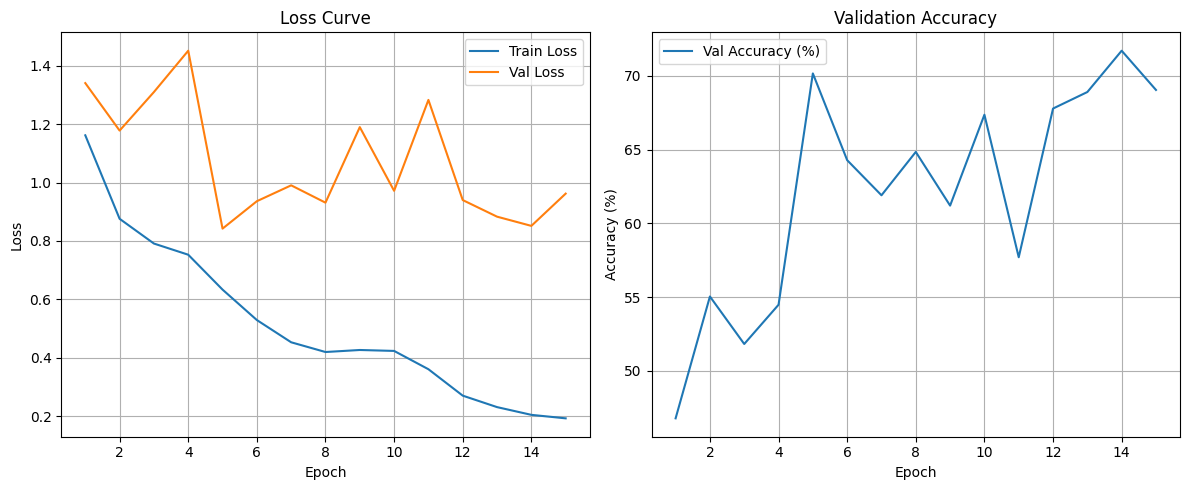

In [35]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, [a * 100 for a in history["val_acc"]], label="Val Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Val loss แกว่ง และไม่ลดตาม train loss

ช่วงหลัง (epoch ~10+) train loss ยังลง แต่ val loss ทรง ๆ

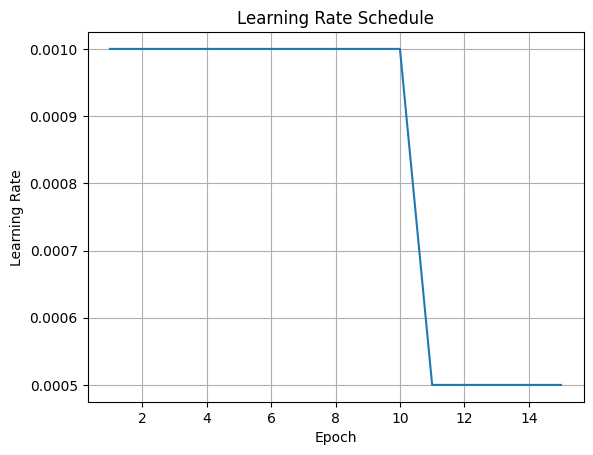

In [36]:
plt.figure()
plt.plot(epochs, history["lr"])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.show()


In [37]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Final Test Accuracy: {test_acc*100:.2f}%")

Final Test Accuracy: 66.39%


In [38]:
torch.save({
    "model_state": model.state_dict(),
    "history": history,
}, "stgcn_trained.pt")
